In [6]:
pip install tensorflow

     |████████████████████████████████| 230.1 MB 740 kB/s eta 0:00:01    |████████▎                       | 59.3 MB 166 kB/s eta 0:17:06�████████▎                      | 67.1 MB 1.0 MB/s eta 0:02:38     |█████████████▎                  | 95.2 MB 2.8 MB/s eta 0:00:48     |███████████████▎                | 109.5 MB 1.7 MB/s eta 0:01:11     |███████████████████▍            | 139.3 MB 774 kB/s eta 0:01:58     |████████████████████▌           | 147.3 MB 725 kB/s eta 0:01:55     |█████████████████████▊          | 156.5 MB 885 kB/s eta 0:01:24     |█████████████████████████       | 180.5 MB 736 kB/s eta 0:01:08
     |████████████████████████████████| 26.7 MB 3.5 MB/s eta 0:00:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
     |████████████████████████████████| 18.1 MB 1.9 MB/s eta 0:00:01
     |███████████████

In [ ]:
import os
import cv2
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib.image import imread
from keras.models import Sequential
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, Input, BatchNormalization, Activation, Embedding, Add, LSTM, SimpleRNN
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from  klearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import resample
from sklearn import preprocessing


In [ ]:
DATA_PATH = './'
METADATA_PATH = './module_metadata.json'

In [2]:
df = pd.read_json(METADATA_PATH, orient='index').sort_index()
df['image_filepath'] = df.image_filepath.apply(lambda x: os.path.join(DATA_PATH, x))
df.head(5)

NameError: name 'pd' is not defined

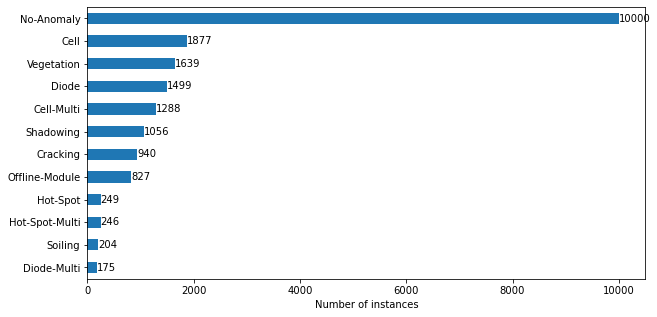

In [5]:
ax = df.anomaly_class.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of instances')
plt.show()

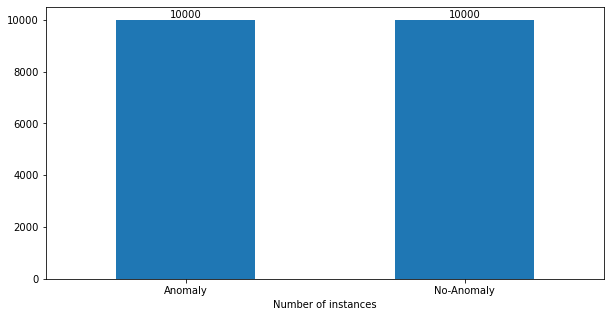

In [6]:
def convert_to_binary(x):
    x = 'Anomaly' if x != 'No-Anomaly' else x
    return x

ax = df.anomaly_class.apply(convert_to_binary).value_counts().plot.bar(figsize=(10,5))
ax.tick_params(labelrotation=0)
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of instances')
plt.show()

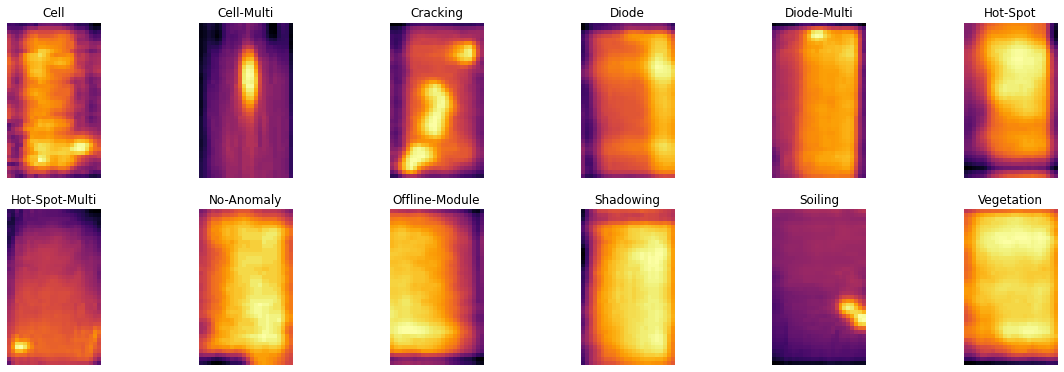

In [7]:
sample = df.groupby('anomaly_class').sample()

plt.figure(figsize=(20,20))
for i, (image_path, class_name) in enumerate(sample.values, start=1):
    image = cv2.imread(image_path, 0)
      
    plt.subplot(6, 6, i)
    plt.imshow(image, cmap='inferno')
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [8]:
#we will only investigate the classification of crystalline silicon pv modules
df = df.query('anomaly_class != ("Hot-Spot", "Hot-Spot-Multi")')
thin_film_df = df.query('anomaly_class == ("Hot-Spot", "Hot-Spot-Multi")')

In [9]:
df['anomaly_class'].unique()

array(['Offline-Module', 'Diode-Multi', 'Diode', 'Shadowing',
       'Cell-Multi', 'Cell', 'Cracking', 'Soiling', 'Vegetation',
       'No-Anomaly'], dtype=object)

In [10]:
#resample the data so that there are equal amounts of each category
df_1=df.loc[df['anomaly_class']=='Offline-Module']
df_2=df.loc[df['anomaly_class']=='Diode']
df_3=df.loc[df['anomaly_class']=='Shadowing']
df_4=df.loc[df['anomaly_class']=='Cell-Multi']
df_5=df.loc[df['anomaly_class']=='Cell']
df_6=df.loc[df['anomaly_class']=='Vegetation']
df_7=df.loc[df['anomaly_class']=='No-Anomaly']
df_8=df.loc[df['anomaly_class']=='Cracking']

df_1_upsample=resample(df_1,replace=True,n_samples=750,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=750,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=750,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=750,random_state=125)
df_5_upsample=resample(df_5,replace=True,n_samples=750,random_state=122)
df_6_upsample=resample(df_6,replace=True,n_samples=750,random_state=123)
df_7_upsample=resample(df_7,replace=True,n_samples=750,random_state=124)
df_8_upsample=resample(df_8,replace=True,n_samples=750,random_state=125)

crystal_df=pd.concat([df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample,df_6_upsample,df_7_upsample,df_8_upsample])

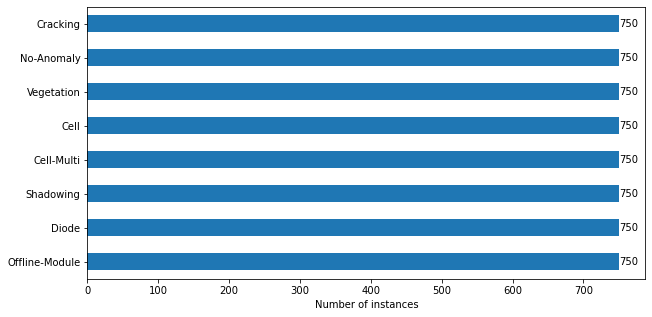

In [11]:
ax = crystal_df.anomaly_class.value_counts().sort_values(ascending=True).plot.barh(figsize=(10,5))
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of instances')
plt.show()

In [12]:
x_train, x_test, y_train, y_test = train_test_split(crystal_df['image_filepath'], crystal_df['anomaly_class'], test_size=0.3, shuffle=True, stratify=crystal_df['anomaly_class'])

In [13]:
#converting image files into arrays of numbers 
x_train_array = []
for image_path in x_train.iloc[0:13653]:
    image = imread(image_path).flatten()
    x_train_array.append(image)

x_test_array = []
for image_path in x_test.iloc[0:5852]:
    image = imread(image_path).flatten()
    x_test_array.append(image)

In [14]:
x_test_df = pd.DataFrame(np.array(x_test_array))
x_train_df = pd.DataFrame(np.array(x_train_array))

le = preprocessing.LabelEncoder()
le.fit(y_test)
y_test_cat = le.transform(y_test)
y_test_cat = to_categorical(y_test_cat)
le.fit(y_train)
y_train_cat = le.transform(y_train)
y_train_cat = to_categorical(y_train_cat)

In [15]:
cnn_model = Sequential()

# Filters = Units in Dense Total number of Neurons
cnn_model.add(Convolution1D(filters = 32, kernel_size = 6, activation='relu', padding = 'same', input_shape = (x_train_df.shape[1], 1))) 
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool1D(pool_size=(3), strides = (2), padding = 'same'))

cnn_model.add(Convolution1D(filters = 32, kernel_size = 6, activation='relu', padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool1D(pool_size=(3), strides = (2), padding = 'same'))

cnn_model.add(Convolution1D( filters = 32, kernel_size = 6, activation='relu', padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool1D(pool_size=(3), strides = (2), padding = 'same'))

# Flatten 
cnn_model.add(Flatten())

cnn_model.add(Dense(units = 64, activation='relu'))
cnn_model.add(Dense(units = 64, activation='relu'))
cnn_model.add(Dense(units = 8, activation='softmax'))

# loss = 'categorical_crossentropy'
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 960, 32)           224       
                                                                 
 batch_normalization (BatchN  (None, 960, 32)          128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 480, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 480, 32)           6176      
                                                                 
 batch_normalization_1 (Batc  (None, 480, 32)          128       
 hNormalization)                                                 
                                                        

In [16]:
history = cnn_model.fit(x_train_df,y_train_cat,epochs = 20, validation_data = (x_test_df, y_test_cat))

Epoch 1/20
132/132 [==============================] - 5s 25ms/step - loss: 1.7617 - accuracy: 0.3610 - val_loss: 1.8885 - val_accuracy: 0.2683
Epoch 2/20
132/132 [==============================] - 3s 24ms/step - loss: 1.3804 - accuracy: 0.5012 - val_loss: 1.6467 - val_accuracy: 0.3983
Epoch 3/20
132/132 [==============================] - 3s 24ms/step - loss: 1.2249 - accuracy: 0.5512 - val_loss: 1.6811 - val_accuracy: 0.4028
Epoch 4/20
132/132 [==============================] - 3s 24ms/step - loss: 1.1116 - accuracy: 0.5890 - val_loss: 1.4735 - val_accuracy: 0.4900
Epoch 5/20
132/132 [==============================] - 3s 24ms/step - loss: 1.0122 - accuracy: 0.6286 - val_loss: 1.3980 - val_accuracy: 0.5067
Epoch 6/20
132/132 [==============================] - 3s 24ms/step - loss: 0.9288 - accuracy: 0.6583 - val_loss: 1.4231 - val_accuracy: 0.5094
Epoch 7/20
132/132 [==============================] - 3s 24ms/step - loss: 0.8684 - accuracy: 0.6719 - val_loss: 1.9248 - val_accuracy: 0.4056

In [17]:
print("Model evaluated with test data: ",cnn_model.evaluate(x_test_df, y_test_cat))

57/57 [==============================] - 0s 5ms/step - loss: 1.6582 - accuracy: 0.6339
Model evaluated with test data:  [1.6582276821136475, 0.6338889002799988]


Accuracy: 63.39%


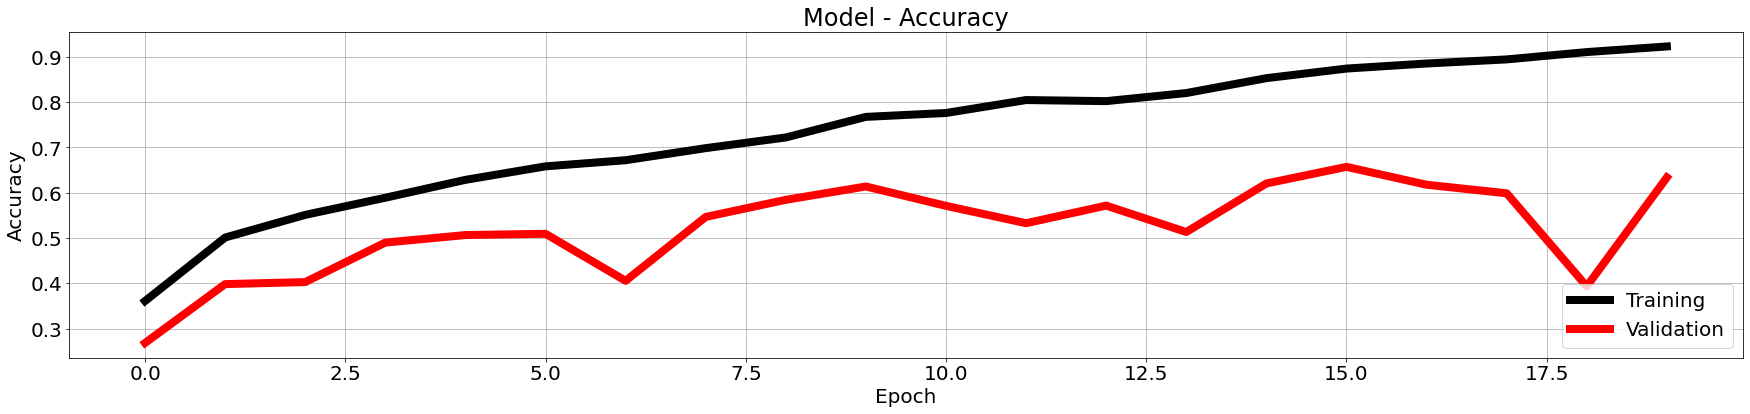

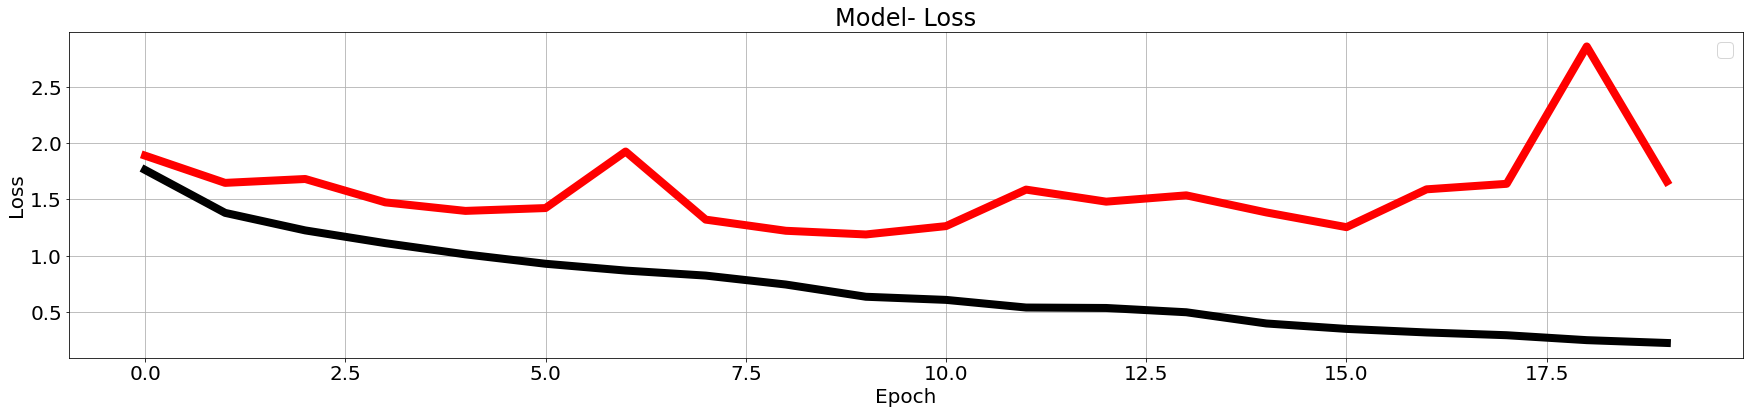

57/57 [==============================] - 0s 5ms/step


In [20]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['font.size'] = (20)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 
evaluate_model(history,x_test_df, y_test_cat,cnn_model)
y_pred=cnn_model.predict(x_test_df)

              precision    recall  f1-score   support

           0       0.54      0.36      0.43       225
           1       0.40      0.61      0.48       225
           2       0.70      0.68      0.69       225
           3       0.87      0.87      0.87       225
           4       0.58      0.68      0.63       225
           5       0.82      0.64      0.72       225
           6       0.71      0.76      0.74       225
           7       0.57      0.47      0.51       225

    accuracy                           0.63      1800
   macro avg       0.65      0.63      0.63      1800
weighted avg       0.65      0.63      0.63      1800



C:\Users\Lelia Deville\AppData\Local\Temp\ipykernel_19528\540683044.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


<Figure size 504x504 with 0 Axes>

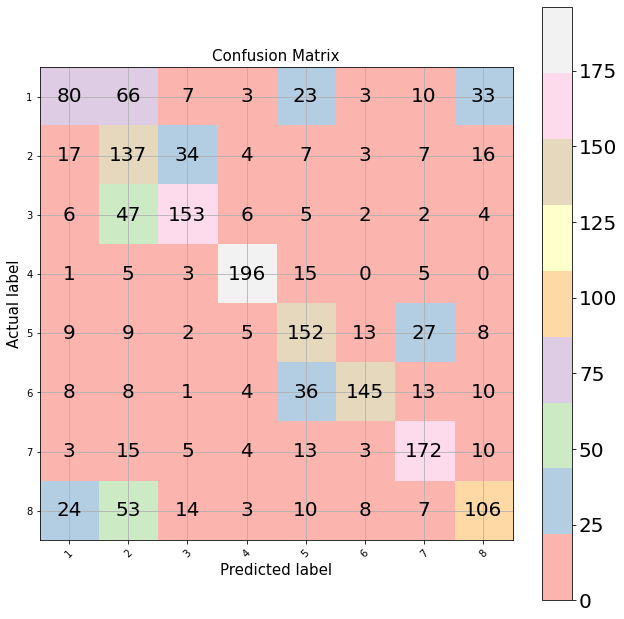

In [21]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

print(classification_report(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1)))

# Plot non-normalized confusion matrix
plt.figure(figsize=(7, 7))
plot_confusion_matrix(cnf_matrix, title='Confusion Matrix')
plt.show()

In [19]:

def plot_confusion_matrix(cm, title='Confusion matrix', cmap='Pastel1'):
    plt.figure(figsize=(9,9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 15)
    plt.colorbar()
    tick_marks = np.arange(8)
    plt.xticks(tick_marks, ["1", "2", "3", "4", "5", "6", "7", "8"], rotation=45, size = 10)
    plt.yticks(tick_marks, ["1", "2", "3", "4", "5", "6", "7", "8"], size = 10)
    plt.tight_layout()
    plt.ylabel('Actual label', size = 15)
    plt.xlabel('Predicted label', size = 15)
    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
            
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'], linewidth=8, c='black')
    plt.plot(history.history['val_accuracy'], linewidth=8, c='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'], linewidth=8, c='black')
    plt.plot(history.history['val_loss'], linewidth=8, c='red')
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction) 